In [56]:
import pandas as pd  # data frame operations
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt  # 2D plotting
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING
import math

from pandas import Series
from statistics import mean
from statistics import median
from math import sqrt

from matplotlib import pyplot

from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

import plotly as py
import plotly.graph_objects as go

#!pip install fbprophet
from fbprophet import Prophet

!pip install pmdarima
import pmdarima as pm
from pmdarima.arima import auto_arima

pd.plotting.register_matplotlib_converters() # was getting error plotting series until entering this..

Import data

In [3]:
# zillow
homes = pd.read_csv('https://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv', encoding='latin_1')

homes.shape # (30434, 292)
len(homes['RegionName'].unique()) # 30,434 zip codes, one for each row.

30434

Arkansas Metro area analysis

In [0]:
ar_homes = homes[homes.State=='AR']

df = pd.DataFrame()
def getMetroAvg(cityName, col):
  global df
  city_homes = ar_homes.loc[ar_homes.City==cityName, col]
  avg = mean(city_homes[~np.isnan( city_homes)])
  df = df.append({'Date':date, 'Avg':avg, 'City':cityName}, ignore_index=True )

for col in ar_homes.columns: 
    date = pd.to_datetime(col, format='%Y-%m', errors='coerce')
    if(date >= pd.to_datetime('01-01-1997')):
      # get metro averages
      getMetroAvg('Hot Springs', col)  
      getMetroAvg('Little Rock', col)  
      getMetroAvg('Fayetteville', col)  
      getMetroAvg('Searcy', col)  

df = df.set_index('Date')

hotSprings_homes = df[df['City']=='Hot Springs']
littleRock_homes = df[df['City']=='Little Rock']
fayetteville_homes = df[df['City']=='Fayetteville']
searcy_homes = df[df['City']=='Searcy']

# Plot results
fig = go.Figure()
fig.add_trace(go.Scatter(x=hotSprings_homes.index, y=hotSprings_homes.Avg, name='Hot Springs',
                          line_color='deepskyblue'))
fig.add_trace(go.Scatter(x=littleRock_homes.index, y=littleRock_homes.Avg, name='Little Rock',
                          line_color='red'))
fig.add_trace(go.Scatter(x=fayetteville_homes.index, y=fayetteville_homes.Avg, name='Fayetteville',
                          line_color='gray'))
fig.add_trace(go.Scatter(x=searcy_homes.index, y=searcy_homes.Avg, name='Searcy',
                          line_color='#0028FF'))
fig.update_layout(title_text='Average Home Sales in Arkansas Metro Areas',
                  xaxis_rangeslider_visible=False)
fig.show()

Predicting avg median housing value by zip code in 2018

In [0]:
# Transpose and make series
def getSeries(df):

  df = df.transpose()

  # row names
  df.insert(0, 'Date', df.index.values)
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m', errors='coerce')

  # col names
  zips = df.iloc[1]
  cols = ['zip_{0}'.format(z) for z in zips]
  cols[0] = 'Date'
  df.columns = cols

  # drop additional info
  df = df.drop('RegionID')
  df = df.drop('City')
  df = df.drop('State')
  df = df.drop('Metro')
  df = df.drop('CountyName')
  df = df.drop('RegionName')
  df = df.drop('SizeRank')

  # make time series
  df = df.set_index('Date')

  # create avg column
  df['zip_median'] = df.median(axis=1)

  # backwards fill for nan values
  df = df.fillna(method='bfill')
  #homes = homes.fillna(method='ffill')

  return df

In [0]:
all_homes = getSeries(homes)
fl_homes = getSeries(homes[homes['State']=='FL'])
ca_homes = getSeries(homes[homes['State']=='CA'])

Calculate Returns

In [0]:
# function to calculate gain percentage (ROI) on previous 2, 5 and 10 years
# source: https://github.com/gioamorim80/Zillow-Time-Series/blob/master/Module%204%20Final%20Project.ipynb
def calculate_gain(ts, plot=True): 
    
    '''Takes a real estate time series and performs calculations on returns over investments
    for periods of 2 and 5 years.'''
    
    # calculates ROI by taking current value, decreasing investment(value at x steps in past) and 
    # dividing by investment. Multiplies by 100 to get percentage number
    roi_2 = (ts - ts.shift(periods=24))/ts.shift(periods=24)*100
    roi_5 = (ts - ts.shift(periods=59))/ts.shift(periods=59)*100
    roi_2.dropna(inplace=True)
    roi_5.dropna(inplace=True)
    
    # plot results
    if plot:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=roi_2.index, y=roi_2.value, name='2-Year Investment',
                                 line_color='deepskyblue'))
        fig.add_trace(go.Scatter(x=roi_5.index, y=roi_5.value, name='5-Year Investment',
                                 line_color='red'))
        fig.update_layout(title_text='Mean Zillow Home Value Index (ZHVI) - ROI Over Time Invested',
                          yaxis_title="ROI (%)", 
                          xaxis_rangeslider_visible=False)
        fig.show()
    
    # saves new ts with returns for 2, 5 and 10 periods
    return roi_2, roi_5

In [0]:
def stationaryTest(df):
  X = df.value
  X = X.astype('float32')

  # Is stationary? Run AD FUller, p-value < .05 ?
  result = adfuller(X)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])

  # LOOK FOR ACF & PACF
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
  fig = plot_acf(X, lags=40, ax=ax1)
  ax1.axhline(y=0,linestyle='--',color= 'gray')
  ax1.axhline(y= - 1.96/np.sqrt(len(df)), linestyle='--',color= 'gray')
  ax1.axhline(y=  1.96/np.sqrt(len(df)), linestyle='--',color= 'gray')
  ax1.set_label('Lags')

  fig = plot_pacf(X, lags=40, ax=ax2)
  ax2.axhline(y=0,linestyle = '--', color = 'gray')
  ax2.axhline(y = -1.96/np.sqrt(len(df)), linestyle = '--', color = 'gray')
  ax2.axhline(y = 1.96/np.sqrt(len(df)), linestyle = '--', color = 'gray')
  ax2.set_label('Lags')




ADF Statistic: -1.089803
p-value: 0.719121


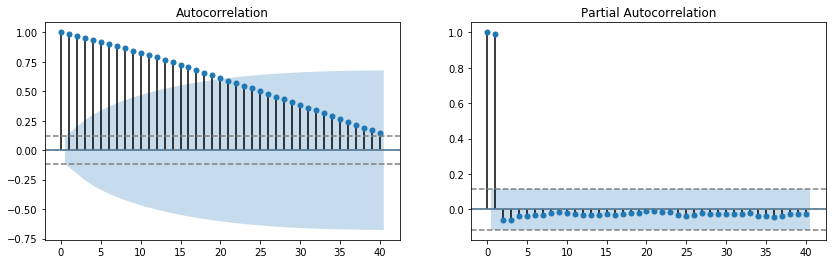

In [216]:
df = pd.DataFrame(data=all_homes['zip_median'].values, index=all_homes.index, columns=['value'])
stationaryTest(df) # p-value: 0.719121

In [0]:
'''
# Get fuller p-values for different lags

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# Make stationary
X = zip_median_roi5.value
X = X.astype('float32')

# difference data

for p in range(0, 40):
  lags = p
  stationary = difference(X, lags)
  result = adfuller(stationary)
  if result[1] < .05:
    print('lags: ' + str(p) + ', p-value: ' + str(result[1]))

#lags: 1, p-value: 0.016
'''

In [0]:
'''
# make stationary with lag = 1, as discovered to be best with AD Fuller test
lags = 1
stationary = difference(X, lags)
stationary.index = df.index[lags:]

# USING STATIONARY TIME SERIES LOOK FOR ACF & PACF
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
fig = plot_acf(stationary, ax=ax1)
ax1.axhline(y=0,linestyle='--',color= 'gray')
ax1.axhline(y= - 1.96/np.sqrt(len(stationary)), linestyle='--',color= 'gray')
ax1.axhline(y=  1.96/np.sqrt(len(stationary)), linestyle='--',color= 'gray')
ax1.set_label('Lags')

fig = plot_pacf(stationary, ax=ax2)
ax2.axhline(y=0,linestyle = '--', color = 'gray')
ax2.axhline(y = -1.96/np.sqrt(len(stationary)), linestyle = '--', color = 'gray')
ax2.axhline(y = 1.96/np.sqrt(len(stationary)), linestyle = '--', color = 'gray')
ax2.set_label('Lags')
'''

In [0]:
'''
# BEST ARIMA params
# CODE RUNS LONG FOR EVALUATION - approximately 
import warnings

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.70)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		lags = 1 # best value discovered with fuller test above
		diff = difference(history, lags)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, lags)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)

warnings.filterwarnings("ignore")
evaluate_models(df['zip_median'].values, p_values, d_values, q_values)

# Best: ARIMA(6, 1, 0) RMSE=139.733
'''

In [0]:
# define a function to run auto arima and search for best model parameters
def find_orders(ts, exog=None):

    stepwise_model = pm.auto_arima(ts, start_p=1, start_q=1, max_p=4, max_q=14,
                                exogenous=exog, 
                                m=12, seasonal=True, stationary=False,
                                stepwise=True, trend='ct',
                                suppress_warnings=True, trace=False, 
                                error_action='ignore')

    return stepwise_model.order, stepwise_model.seasonal_order

In [0]:
def fit_sarimax_model(ts, exog=None, order=(1,1,1), seasonal_order=(0, 0, 0, 12), summary=True, plot=True):
  
    # fit model with exog
    model = sm.tsa.statespace.SARIMAX(ts, 
                                  exog = exog,  
                                  order=order,
                                  seasonal_order=seasonal_order,
                                  trend='ct',
                                  enforce_stationarity=True,
                                  enforce_invertibility=False)

    output = model.fit(d=0)
    
    if summary==True:
        print(output.summary())

    if plot==True:
        # plot model diagnostics
        output.plot_diagnostics(figsize=(15, 18))
        plt.show()
        
    return output

In [0]:
def get_predictions(test, exog, model_output, plot=True, show=True):
    
    # Use the model to forecast twelve months into 2018 and store the confidence intervals
    pred = model_output.get_prediction(start=pd.to_datetime('2018-01-01'), end=pd.to_datetime('2018-12-01'), dynamic=False, exog=exog)
    pred_ci = pred.conf_int()
    
    # Plot the actual results for 2018 vs the projected results. 
    ax = test['2018-01-01':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(8,6))
    
    
    if plot:
        #Plot observed and predicted values with confidence interval
        ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

        ax.set_xlabel('Date')
        ax.set_ylabel('Household Value')
        plt.legend(loc='upper left')
        plt.show()

    
    if show:
        
        # Obtain the predicted mean, merge with the actual values, and compute the MSE. 
        y_pred = pred.predicted_mean.reset_index()
        y_pred.columns = ['date', 'value']
        
        y_test = test.reset_index()
        
        # Compute the mean square error / RMSE
        mse = mean_squared_error(y_test.value, y_pred.value)
        rmse = math.sqrt(mse)
        r2 = r2_score(y_test.value, y_pred.value)

        # Print the results. 
        print('RMSE: ' +  str(format(round(rmse, 3))))
        print('R-squared: ' + str(format(round(r2, 3))))


In [0]:
def get_future(ds, plot):

    # Get forecast and confidence interval from base model, by steps 60
    
    future_2y = model_output.get_forecast(steps=24, dynamic=True)
    future_conf_2y = future_2y.conf_int(steps=24)

    future_5y = model_output.get_forecast(steps=60, dynamic=True)
    future_conf_5y = future_5y.conf_int(steps=60)    

    if plot: # plot results

        # 5 yr
        ax = ds.plot(label='Observed', figsize=(12, 8))
        future_5y.predicted_mean.plot(ax=ax, label='Forecast')
        ax.fill_between(future_conf_5y.index,
                        future_conf_5y.iloc[:, 0],
                        future_conf_5y.iloc[:, 1], color='k', alpha=.25)
        ax.set_xlabel('Date')
        ax.set_ylabel('Returns')
        ax.set_title('5-Year Forecast')
        ax.legend()
        plt.show()        

    df_out = future_conf_5y
    df_out['yhat'] = future_5y.predicted_mean
    df_out.columns = ['yhat_lower', 'yhat_upper', 'yhat']


    gain_df = pd.DataFrame({'value':df_out['yhat'].values, 'date':df_out.index})
    gain_df = gain_df.set_index('date')
    #gain_df.loc['2025-01'] = 0

    roi = calculate_gain(gain_df, plot=False)
    roi_2y = pd.DataFrame(roi[0])
    roi_5y = pd.DataFrame(roi[1])
    roi_2y.index = pd.date_range(start='1/1/2022', periods=36, freq='M')
    roi_5y.index = pd.date_range(start='12/1/2024', periods=1, freq='M')

    #print('2-Year ROI: ' + str(roi_2y.loc['2022-01'].value[0]) + '%')
    #print('5-Year ROI: ' + str(roi_5y.loc['2024-12'].value[0]) + '%')

    # show prediction for end of step-period
    maximum_2y = future_conf_2y.iloc[-1,1]
    minimum_2y = future_conf_2y.iloc[-1,0]    
    maximum_5y = future_conf_5y.iloc[-1,1]
    minimum_5y = future_conf_5y.iloc[-1,0]

    #return (df_out) # returns predicted values
    return (pd.DataFrame({'roi_2y':roi_2y.loc['2022-01'].value[0], 
                          'min_conf_2y': minimum_2y, 
                          'max_conf_2y': maximum_2y, 
                          'roi_5y':roi_5y.loc['2024-12'].value[0], 
                          'min_conf_5y': minimum_5y, 
                          'max_conf_5y': maximum_5y, 
                          }, index=[0]))

In [12]:
# base model    

# find best arima/sarimax params, without exog's
df = pd.DataFrame(data=all_homes['zip_median'].values, index=all_homes.index, columns=['value'])
find_orders(df) # ((0, 2, 1), (0, 0, 0, 12))

zip_median_output = fit_sarimax_model(df, order=(0, 2, 1), seasonal_order=(0, 0, 0, 12), plot=False)  # AIC: 4217.217

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                           Statespace Model Results                           
Dep. Variable:                  value   No. Observations:                  285
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -2104.608
Date:                Sun, 16 Feb 2020   AIC                           4217.217
Time:                        06:31:55   BIC                           4231.799
Sample:                    04-01-1996   HQIC                          4223.064
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.9102     88.687     -0.033      0.974    -176.733     170.912
drift          0.0225      0.583      0.039      0.969      -1.119       1.165
ma.L1         -0.0740      0.012     -6.244      0.0

In [0]:
# Dept of Labor Employment Dataset
# https://beta.bls.gov/dataViewer/view/timeseries/CES0000000001;jsessionid=542AB1B7EFC43613AD715045DF37B0B6
employ = pd.read_csv('https://github.com/vksyr/IST718/raw/master/DOL_Employment.csv')
employ = employ.drop('Date' , axis=1)
employ.index = all_homes.index

# Dept of Labor Unemployment Rate Dataset
# https://beta.bls.gov/dataViewer/view/timeseries/CES0000000001;jsessionid=542AB1B7EFC43613AD715045DF37B0B6
unemploy = pd.read_csv('https://github.com/vksyr/IST718/raw/master/DOL_Unemployment.csv')
unemploy = unemploy.drop('Date' , axis=1)
unemploy.index = all_homes.index

# 30-Year Fixed Mortgage Rates
# http://www.freddiemac.com/pmms/pmms_archives.html
mtg = pd.read_csv('https://github.com/vksyr/IST718/raw/master/30YearFixedMortgage.csv')
mtg = mtg.drop('Date' , axis=1)
mtg.index = all_homes.index

# Delinquencies on All Loans and Leases, Secured by Real Estate, Single-Family Residential Mortgages, 
# Booked in Domestic Offices, All Commercial Banks 
# https://fred.stlouisfed.org/series/DALLSRESFRMACBEP
# Quarterly
foreclosures = pd.read_csv('https://github.com/vksyr/IST718/raw/master/Foreclosures.csv')
foreclosures['Date'] = pd.to_datetime(foreclosures['Date'], format='%m/%d/%Y', errors='coerce')
foreclosures = foreclosures.set_index('Date')

In [0]:
# since foreclosures is quarterly, ffill unlisted months
newDf = pd.DataFrame(index=all_homes.index)
newDf['value'] = 0

for index, row in foreclosures.iterrows():
  date = str(index)[:7]
  newDf.loc[date].value = row.value

newDf = newDf.replace(0,np.NaN)
foreclosures = newDf.fillna(method='ffill')

In [18]:
# Plot exogs with home sales

from plotly.subplots import make_subplots

layout = go.Layout(legend = dict(x = 0.1, y = 0.9))

fig = make_subplots(rows=5, cols=1)
fig.append_trace(go.Scatter(x=df.index, y=df.value, name='Home Sales',
                          line_color='gray'), row=1, col=1)
fig.append_trace(go.Scatter(x=employ.index, y=employ.value, name='# Employed', 
                          line_color='deepskyblue'), row=2, col=1)
fig.append_trace(go.Scatter(x=unemploy.index, y=unemploy.value, name='Unemployment Rate', 
                          line_color='#0028FF'), row=3, col=1)
fig.append_trace(go.Scatter(x=foreclosures.index, y=foreclosures.value, name='Foreclosures',
                          line_color='orange'), row=4, col=1)
fig.append_trace(go.Scatter(x=mtg.index, y=mtg.value, name='30-Year Fixed Mortgage Rate',
                          line_color='red'), row=5, col=1)

fig.update_layout(title_text='Average Home Sales in Arkansas Metro Areas',
                          xaxis_rangeslider_visible=False, legend = dict(x = 0.6, y = 1.2))

fig.update_layout(height=600, width=600, title_text="Home Sales vs Other Factors (Natl)")
fig.show()

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  252
Model:             SARIMAX(2, 1, 0)x(1, 0, 1, 12)   Log Likelihood               -1855.329
Date:                            Sun, 16 Feb 2020   AIC                           3726.658
Time:                                    08:14:06   BIC                           3754.861
Sample:                                01-01-1997   HQIC                          3738.007
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             8.1567     27.471      0.297      0.767     -45.686      62.000
drift         

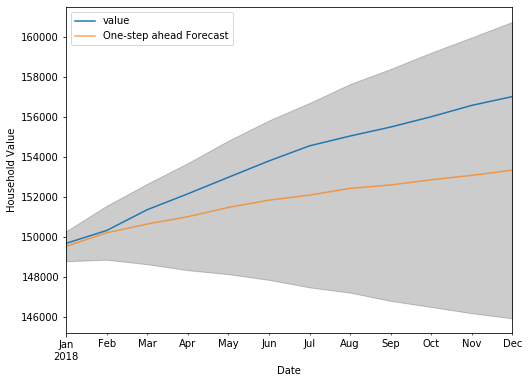

RMSE: 2325.693
R-squared: 0.02


In [80]:
## SARIMAX w/ Exogs ##

# The 4 exogs below can be added to the model, but it was discovered that just the top one is significant
exogs = pd.DataFrame(data=employ.values, index=employ.index, columns=['Natl_Employment_#'])
#exogs['Natl_Unemployment_Rate'] = unemploy.values
#exogs['Foreclosures'] = foreclosures.values
#exogs['30_Year_Mortgage'] = mtg.values

# try shifting values to detect lagged significance... mortgage still not significant.
#exog_shift = exogs.shift(periods=-4)
#exog_shift = exogs_shift.fillna(method='ffill')

# train/test datasets
homes_before2018 = pd.DataFrame(all_homes[col].loc['1997':'2017'], index=all_homes.loc['1997':'2017'].index)
homes_2018 = pd.DataFrame(all_homes[col].loc['2018'], index=all_homes.loc['2018'].index)
train = homes_before2018
train.columns = ['value']
test = homes_2018
test.columns = ['value']

# find best arima/sarimax params, witg exog's
#df = pd.DataFrame(data=all_homes['zip_median'].values, index=all_homes.index, columns=['value'])
#find_orders(df, exog) # ((2, 1, 0), (1, 0, 1, 12))

# create model
model_output = fit_sarimax_model(train, exog=exogs.loc['1997':'2017'], order=(2, 1, 0), seasonal_order=(1, 0, 1, 12), plot=False)  # AIC: 4186.809

# get predictions
get_predictions(test, exog=exogs.loc['2018'], model_output=model_output, plot=True, show=True)

In [0]:
import warnings
warnings.filterwarnings("ignore")

i=0
for col in all_homes.columns[27545:]:
    i = i+1
    if i % 300 == 0:
      print(str(i/300) + '%')
    
    df = pd.DataFrame(data=all_homes[col].values, index=all_homes.index, columns=['value'])
    model_output = fit_sarimax_model(df, order=(0, 2, 1), seasonal_order=(0, 0, 0, 12), plot=False, summary=False)

    forecast = get_future(df, plot=False)

    #f_out = pd.DataFrame({'zip':col, 'date': forecast.index, 
    #                     'yhat':forecast['yhat'], 'yhat_lower':forecast['yhat_lower'], 'yhat_upper':forecast['yhat_upper'], } )

    roi_out = pd.DataFrame({'zip':col, 
                            'roi_2y':forecast['roi_2y'], 
                            'min_conf_2y':forecast['min_conf_2y'],
                            'max_conf_2y':forecast['max_conf_2y'],
                            'roi_5y':forecast['roi_5y'],
                            'min_conf_5y':forecast['min_conf_5y'],
                            'max_conf_5y':forecast['max_conf_5y']
                            })

    roi_out.to_csv('/content/drive/My Drive/IST718/home_zip_predictions_ALL.csv', mode='a', header=False)



In [0]:
# analyze above

pred_rois = pd.read_csv('https://github.com/vksyr/IST718/raw/master/home_zip_predictions_ALL.csv',)

pred_rois.columns = ['--', 'zip', 'roi_2y', 'min_conf_2y', 'max_conf_2y', 'roi_5y', 'min_conf_5y', 'max_conf_5y']
pred_rois['conf_int_size_2y'] = pred_rois['max_conf_2y'] - pred_rois['min_conf_2y']
pred_rois['conf_int_size_5y'] = pred_rois['max_conf_5y'] - pred_rois['min_conf_5y']

avg_conf_inv_2y = pred_rois['conf_int_size_2y'].mean()
avg_conf_inv_5y = pred_rois['conf_int_size_5y'].mean()

print('Avg 2-Yr 95% Ci: ' + str(avg_conf_inv_2y))
print('Avg 5-Yr 95% Ci: ' + str(avg_conf_inv_5y))


# sort by size
pred_rois.sort_values(by=['roi_2y'], ascending=False)[0:10]

In [0]:

ts = pd.DataFrame(data=f_out['yhat'].values, index=f_out.index, columns=['value'])


# calculates ROI by taking current value, decreasing investment(value at x steps in past) and 
# dividing by investment. Multiplies by 100 to get percentage number
roi_2 = (ts - ts.shift(periods=24))/ts.shift(periods=24)*100
roi_5 = (ts - ts.shift(periods=60))/ts.shift(periods=60)*100
roi_2.dropna(inplace=True)
roi_5.dropna(inplace=True)

# plot results
if 1==2:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=roi_2.index, y=roi_2.value, name='2-Year Investment',
                              line_color='deepskyblue'))
    fig.add_trace(go.Scatter(x=roi_5.index, y=roi_5.value, name='5-Year Investment',
                              line_color='red'))
    fig.update_layout(title_text='Mean Zillow Home Value Index (ZHVI) - ROI Over Time Invested',
                      yaxis_title="ROI (%)", 
                      xaxis_rangeslider_visible=False)
    fig.show()
  
# saves new ts with returns for 2, 5 and 10 periods
roi_2.loc['2022-01'].value[0]


In [0]:
'''
# residuals
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())
# plot
residuals.hist(ax=pyplot.gca())
pyplot.show()

# mean: -11.894349
'''

Prophet

In [0]:
# try exog with binning employed

exogs = pd.DataFrame(data=employ.values, index=employ.index, columns=['Natl_Employment_#'])
empl_bins = pd.cut(exogs['Natl_Employment_#'], 7, labels=["extrememly-low", "low", "medium-low", "medium", "medium-high", "high", "extremely-high"])
empl_bins_df = pd.DataFrame(empl_bins, index=all_homes.index)
empl_bins_df = empl_bins_df.reset_index()
empl_bins_df.columns = ['ds', 'holiday']

In [69]:
import logging
from fbprophet import Prophet

logging.getLogger('fbprophet').setLevel(logging.WARNING)

predictions = pd.DataFrame()
col = 'zip_median'
#i=0
#for col in ca_homes.columns:
#  i = i+1
#  if i % 16.86 == 0:
#    print(str(i/16.86) + '%')
if 1==1:
  # train/test datasets
  homes_before2018 = pd.DataFrame(ca_homes[col].loc['1997':'2017'], index=ca_homes.loc['1997':'2017'].index)
  homes_2018 = pd.DataFrame(all_homes[col].loc['2018'], index=all_homes.loc['2018'].index)
  train = homes_before2018
  test = homes_2018

  train = train.reset_index()
  train.columns = ['ds', 'y']
  
  
  # set the uncertainty interval to 95% (the Prophet default is 80%)
  # set to 6 months and seasonality change point set to 1 month. 
  m1 = Prophet(interval_width=.95, holidays=empl_bins_df, changepoint_prior_scale=6, yearly_seasonality=True, 
              seasonality_prior_scale=1)
  m1.add_seasonality(name='monthly', period=120, fourier_order=4)
  m1.fit(train)

  # Look at the next 12 months. 
  future_dates = m1.make_future_dataframe(periods=12, freq='MS')


  # Forecast next 12 months with confidence intervals
  forecast = m1.predict(future_dates)
  forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


  predictions = pd.DataFrame({'zip':col, 'date': forecast['ds'], 'yhat':forecast['yhat'], 'yhat_lower':forecast['yhat_lower'], 'yhat_upper':forecast['yhat_upper'] } )
  #predictions.to_csv('/content/drive/My Drive/IST718/home_zip_predictions_CA_1146.csv', mode='a', header=False)

  # Compute the mean square error / RMSE
  mse_prophet = mean_squared_error(test['zip_median'].values, forecast[forecast['ds']>='2018-01-01'].yhat.values)
  r2_prophet = r2_score(test['zip_median'].values, forecast[forecast['ds']>='2018-01-01'].yhat.values)

  # Print the results. 
  print('RMSE: ' +  str(format(round(sqrt(mse_prophet), 3))))
  print('R-squared: ' + str(format(round(r2_prophet, 3))))


  #Plot observed and predicted values with confidence interval
  ax.fill_between(pred_ci.index,
              pred_ci.iloc[:, 0],
              pred_ci.iloc[:, 1], color='k', alpha=.2)

  ax.set_xlabel('Date')
  ax.set_ylabel('Household Value')
  plt.legend(loc='upper left')
  plt.show()



RMSE: 306579.223
R-squared: -17028.326


Maps

In [0]:
# get state means in december
dec_arr = np.array(pd.date_range(start='12/1/1997', end='12/01/2018', freq='12M'))
cols = np.array(['State'])

for mon in dec_arr: 
    cols = np.append(cols, pd.to_datetime(mon).strftime('%Y-%m'))

dec_homes = homes[cols]
dec_homes = dec_homes.groupby(['State']).mean()
dec_homes['avg'] = dec_homes.mean(axis=1)

dec_homes = pd.DataFrame(dec_homes['avg'])
dec_homes = dec_homes.reset_index()
dec_homes.columns = ['State', 'Avg']

# map!
import plotly.express as px
fig = px.choropleth(dec_homes, locationmode="USA-states", locations="State", scope="usa",                     color="Avg", # lifeExp is a column of gapminder
                    #hover_name="state", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

